In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Constants for the Code

V2 = 0
V3 = 256000 #Newtons
E_al = 10.5 *10**3* 6.89476 *10**6 #Pa #Youngs Modulus of aluminium, the material of stringer
#0.020 − 0.062𝑖𝑛 thickness range for the “L” direction
R = 1.95 #m #Distance from origion to LE
A_s = 150 * (1/1000)**2 #m^2 #Stringer Area
t = 2.95/1000 #m #Thickness
c = 8*R #Chord

print("E_al 2024-T861:", E_al/(10**9), "GPa")

#x2c = 1.222*R
#x3c = 0.2974*R

x2i = np.array([
    7*R,
    R,
    0,
    -R,
    -2*R/3,
    R
])

x3i = np.array([
    0,
    6/7*R,
    R,
    0,
    -R/3,
    -6*R/23
])

len = np.size(x2i)

x2c = (7*R -2*R/3 + R)/6
x3c = (6/7*R + R - R/3 - 6*R/23)/6

print(x2c/R, x3c/R)

x2i_c = x2i-x2c
x3i_c = x3i-x3c

H22c = 0
H33c = 0
H23c = 0

for i in range(len):
    #print(x2i[i])
    H22c += E_al*A_s*(x3i_c[i])**2
    H23c += E_al*A_s*(x3i_c[i])*(x2i_c[i])
    H33c += E_al*A_s*(x2i_c[i])**2
#This method is faster and only yields errors in the float, ie e-15

print("H22c: ", H22c)
print("H23c: ", H23c)
print("H33c: ", H33c)

del_fi = np.array([]) #shear flow due to the presence of stringers, i

for i in range(len):
    shearflowinx2 = x2i_c[i]*(H22c*V2 - H23c*V3)/(H22c*H33c - (H23c)**2)
    shearflowinx3 = x3i_c[i]*(H23c*V2 - H33c*V3)/(H22c*H33c - (H23c)**2)

    calc = -E_al*A_s*( shearflowinx2 - shearflowinx3)
    del_fi = np.append(del_fi, calc)
#print(del_fi)

#We make a cut along 12
#therefore, our shearflow in the skin calcs start at cut = 2

cut = 1
f_ij = np.zeros(len)
f_ij[cut-1] = 0

for i in range(cut,np.size(f_ij)):
    if(i+1>5):
        print("here",f_ij[i-cut])
        
        print("here index",i)
        f_ij[i] = f_ij[i-cut] + del_fi[cut-1]
        print("here shear flow: ", f_ij[i])
    else:
        
        f_ij[i] = f_ij[i-cut] + del_fi[i+1] #f_23 = f_12 + del_fi(2)

print("Open Shear Flow for skin sections, 12-61 \n",f_ij)



    


E_al 2024-T861: 72.39498 GPa
1.2222222222222223 0.21048999309868874
H22c:  68050584.36934105
H23c:  -29940944.958260868
H33c:  1795449800.235
here 42436.3638873343
here index 5
here shear flow:  51595.98164891336
Open Shear Flow for skin sections, 12-61 
 [     0.         -61721.914884   -41856.40477626   4312.75596654
  42436.36388733  51595.98164891]


Now time to calculate the distance between stringers

To do this, We will look at x2i and x23, given these points we can find the distance according to the following.

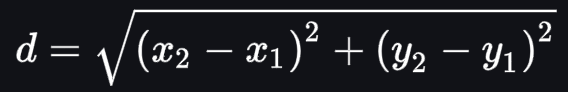

In [89]:
#Closing Shear Flow calculations

#print(x2i)
#print(x3i)

l_i = np.zeros(len)

for i in range(len-1):
    l_i[i] = np.sqrt((x2i[i+1] - x2i[i])**2 + (x3i[i+1] - x3i[i])**2)
    #To get the last distance to close out polygon
    print(i)
    l_i[i+1] = np.sqrt((x2i[i] - x2i[i+1])**2 + (x3i[i] - x3i[i+1])**2)

print(l_i)

0
1
2
3
4
[11.81878477  1.96979746  2.75771645  0.91923882  3.25307038  3.25307038]
